In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import pandas as pd

from functools import partial
from itertools import chain
from tqdm import tqdm
from sklearn.manifold import TSNE
from collections import defaultdict, Counter

from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve

In [2]:
BASE_DATA_DIR = '/home/mikhail/bioinformatics/data/fragment_data'

In [3]:
def group_folds(features, target, group_labels, n_splits=5):
    group_kfold = GroupKFold(n_splits=n_splits)
    
    return group_kfold.split(features, target, group_labels)
    

def stratified_folds(features, target, n_splits=5):
    stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True)
    
    return stratified_kfold.split(features, target)

In [4]:
def run_random_forest(features, target, folds):
    pred = np.zeros_like(target, dtype=np.int)
    pred_proba = np.zeros_like(target, dtype=np.float32)
    
    for train_index, test_index in tqdm(folds):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = target[train_index], target[test_index]

        model = RandomForestClassifier(class_weight='balanced', n_estimators=50, n_jobs=8)
        model.fit(X_train, y_train)
        
        pred[test_index] = model.predict(X_test)
        pred_proba[test_index] = model.predict_proba(X_test)[:, 1]
        
    return pred_proba


def draw_results(target, pred_proba):
    plt.figure(figsize=(20, 10))

    precision, recall, thresholds = precision_recall_curve(target, pred_proba)
    plt.plot(precision, recall, c='r')
    
    xs = np.arange(0, 1.01, 0.1)
    plt.scatter(xs, xs)
    
    plt.figure(figsize=(20, 10))

    plt.hist(pred_proba[target], color='r', alpha=0.5, bins=100, density=True);
    plt.hist(pred_proba[~target], color='b', alpha=0.5, bins=100, density=True);
    
    plt.show()

In [5]:
class Experiment:
    def __init__(self, dataset, dataset_description):
        self.features, self.target, self.pdb_ids, self.chain_ids, self.pair_index, self.feature_description = dataset
        self.experiment_description = [dataset_description]
        self.chain_labels = np.array(['{}_{}'.format(pdb_id, chain_id) 
                                      for pdb_id, chain_id in zip(self.pdb_ids, self.chain_ids)])
    
    def make_experiment(self):
        raise NotImplementedError
    
    def run(self):
        features, target, folds = self.make_experiment()
        
        description = 'Experiment {}'.format('//'.join(self.experiment_description))
        print(description)
        print('target.mean={}'.format(target.mean()))
        
        pred_proba = run_random_forest(features, target, folds)

        draw_results(target, pred_proba)
        
        pair_ids = list(zip(self.pdb_ids, self.chain_ids, self.pair_index))

        return target, pred_proba, pair_ids

    
class SmallChainsExperiment(Experiment):
    def make_experiment(self):
        keys = ['4y4o', '6qzp']
        
        self.experiment_description.append('pdb_ids={} excluded'.format(keys))
        
        mask = ~np.isin(self.pdb_ids, keys)
        
        features = self.features[mask]
        target = self.target[mask]
        group_labels = self.chain_labels[mask]
        folds = group_folds(features, target, group_labels)
        
        return features, target, folds

In [6]:
def load_dataset(data_dir):
    features = np.load(os.path.join(data_dir, 'features.npy'))
    target = np.load(os.path.join(data_dir, 'target.npy'))
    pdb_ids = np.load(os.path.join(data_dir, 'pdb_ids.npy'))
    chain_ids = np.load(os.path.join(data_dir, 'chain_ids.npy'))
    pair_index = [tuple(item) for item in np.load(os.path.join(data_dir, 'pair_index.npy'))]
    
    with open(os.path.join(data_dir, 'description.pickle'), 'rb') as infile:
        feature_description = pickle.load(infile)
    
    return features, target, pdb_ids, chain_ids, pair_index, feature_description


def dataset_descr(exp_id):
    return dict([p.split('=') for p in exp_id.split('.')])

In [7]:
datasets = {}

for exp_id in os.listdir(BASE_DATA_DIR):
    descr = dataset_descr(exp_id)
    
    if descr['es'] == 'bow_wo_distance':
        datasets[descr['dt']] = load_dataset(os.path.join(BASE_DATA_DIR, exp_id))

In [8]:
experiments = {dt: SmallChainsExperiment(dataset, dt) for dt, dataset in datasets.items()}

In [9]:
def get_threshold(approx_precision, target, pred_proba):
    precision, recall, thresholds = precision_recall_curve(target, pred_proba)

    index = np.argmin(np.abs(precision - approx_precision))
    threshold = thresholds[index]

    print(precision[index], recall[index])

    return threshold

In [10]:
approx_precisions = {
    '4': 0.14, 
    '8': 0.19, 
    '11': 0.23
}

0it [00:00, ?it/s]

Experiment 4//pdb_ids=['4y4o', '6qzp'] excluded
target.mean=0.04419889502762431


5it [00:02,  2.09it/s]


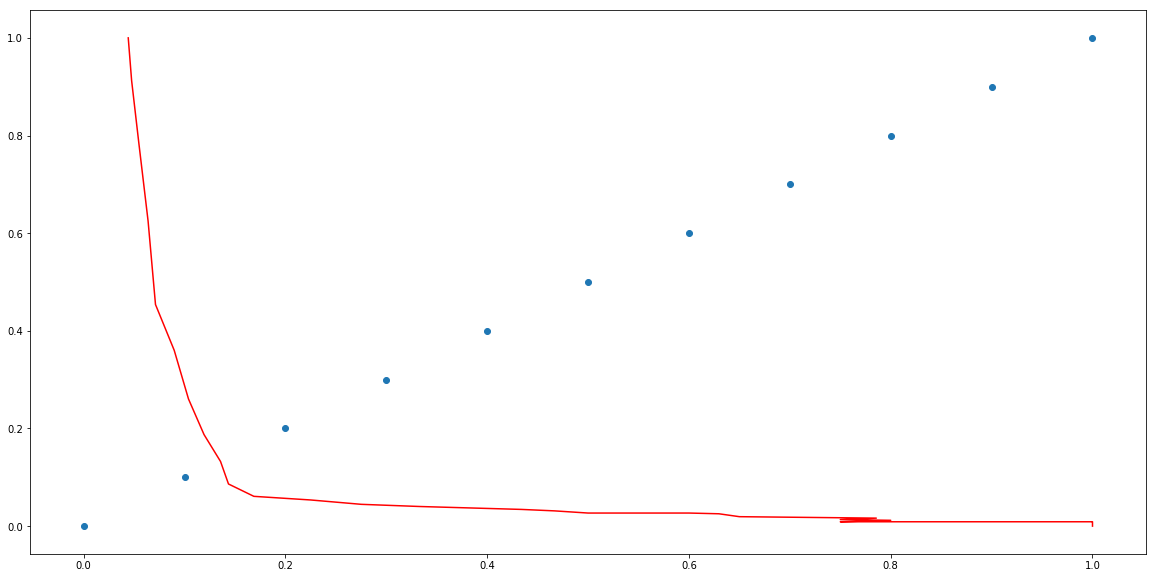

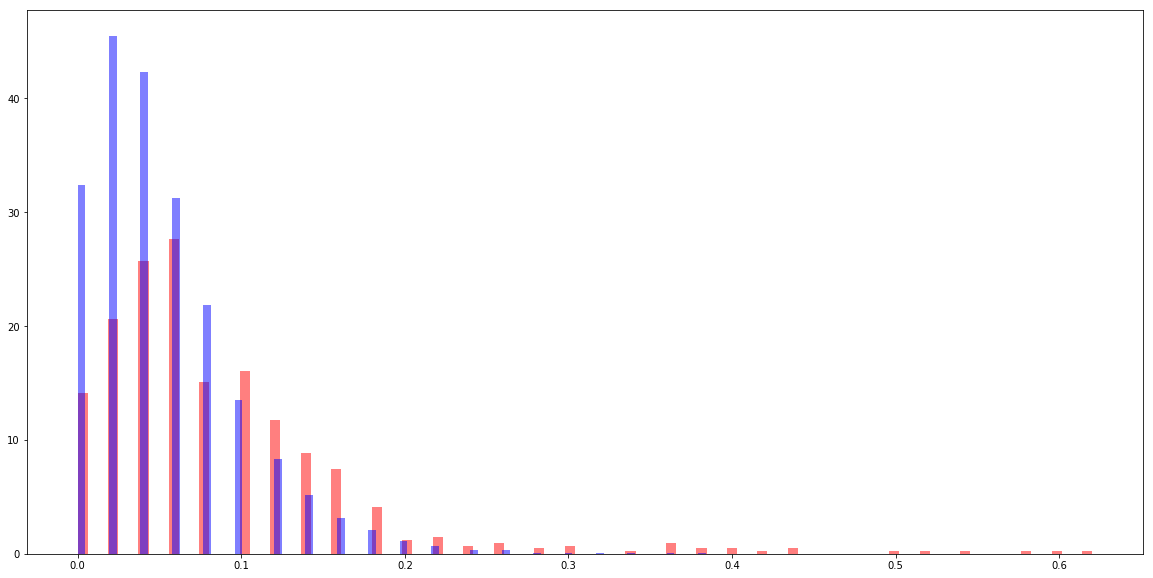

0it [00:00, ?it/s]

0.14356435643564355 0.08630952380952381
shapes:  (15204,) (15204,) 15204
Experiment 8//pdb_ids=['4y4o', '6qzp'] excluded
target.mean=0.10186941208344621


5it [00:02,  1.98it/s]


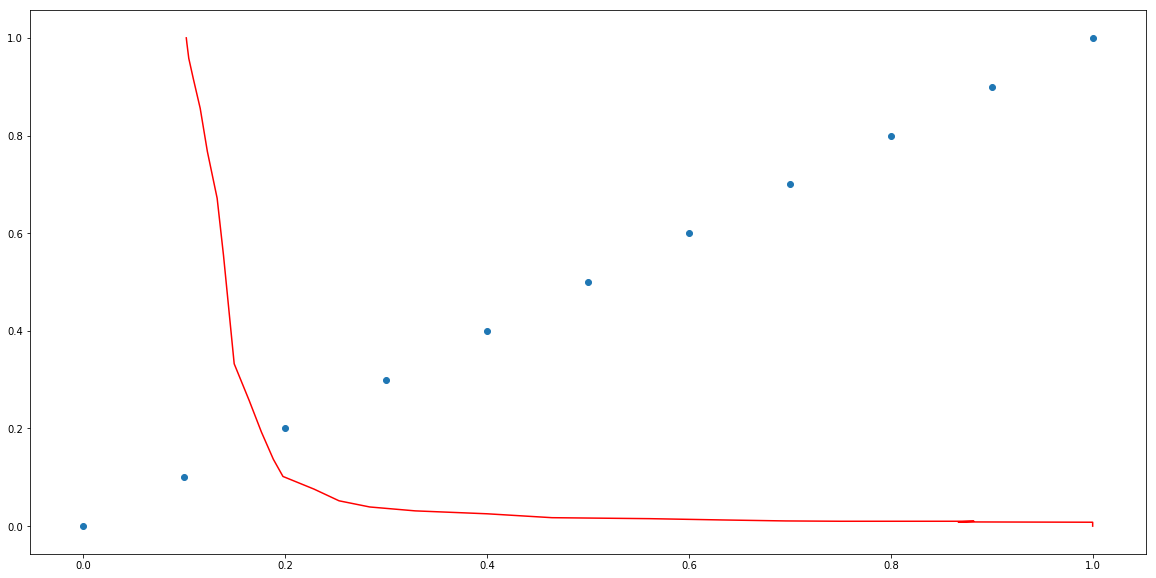

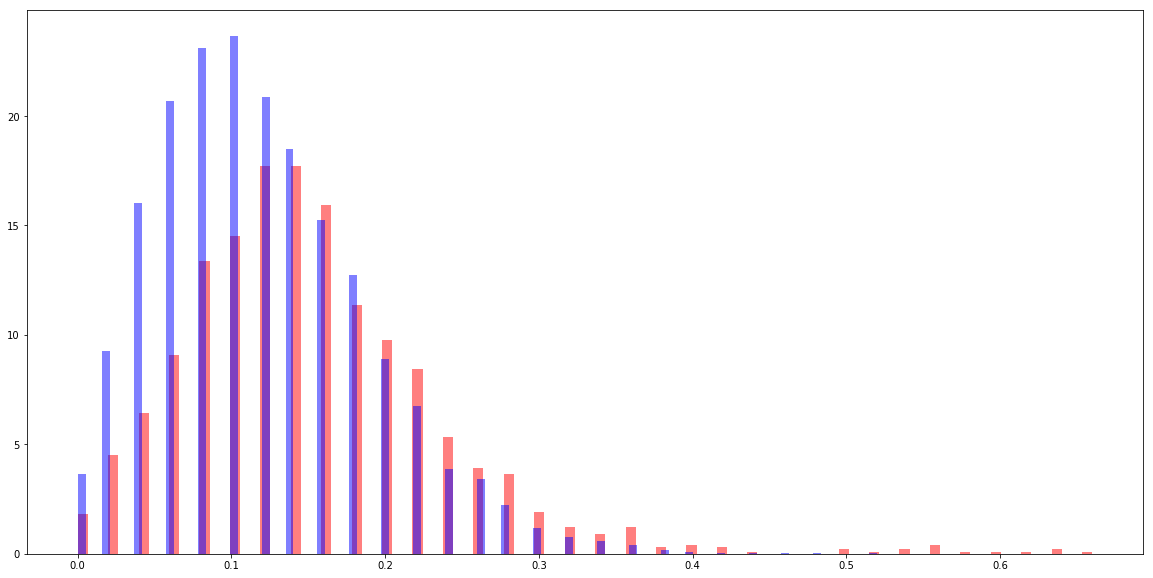

0it [00:00, ?it/s]

0.18812785388127853 0.13696808510638298
shapes:  (14764,) (14764,) 14764
Experiment 11//pdb_ids=['4y4o', '6qzp'] excluded
target.mean=0.1683381088825215


5it [00:02,  2.01it/s]


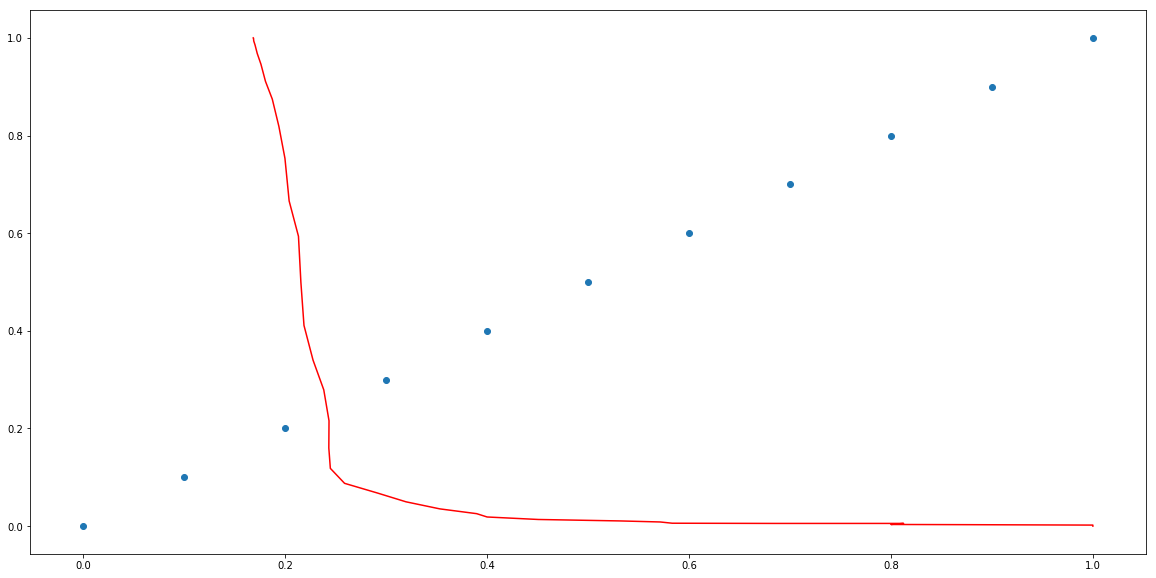

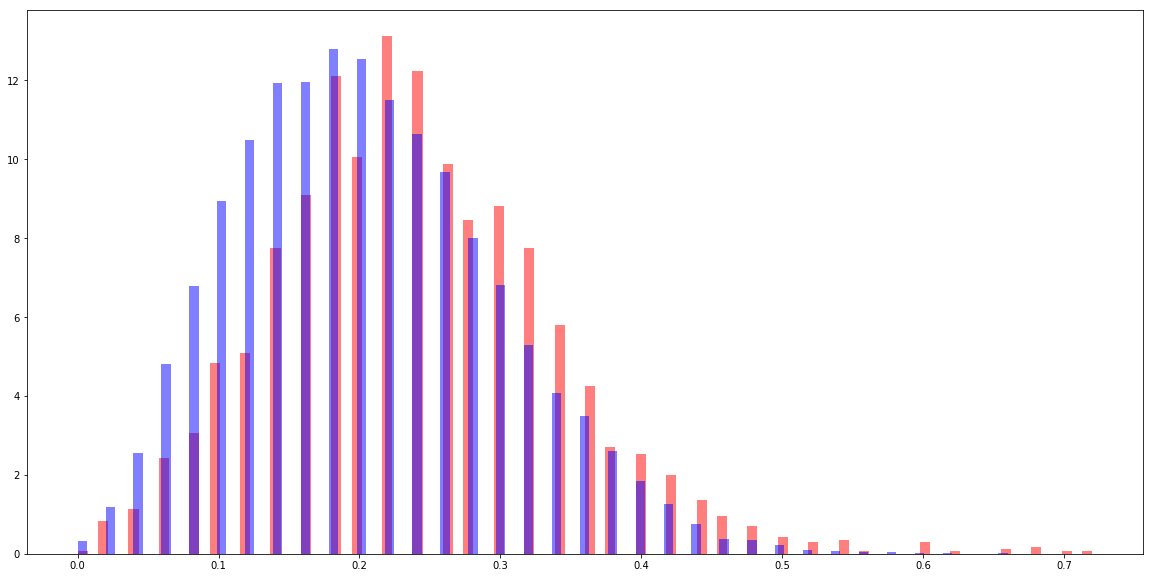

0.22757049273711194 0.34
shapes:  (13960,) (13960,) 13960


In [11]:
all_pairs = {}
pairs = defaultdict(list)

for dt in ['4', '8', '11']:
    approx_precision = approx_precisions[dt]
    target, pred_proba, pair_ids = experiments[dt].run()
    threshold = get_threshold(approx_precision, target, pred_proba)
    true_positive = (pred_proba > threshold) & target
    false_negative = (pred_proba <= threshold) & target
    all_pairs[dt] = pair_ids
    
    print('shapes: ', true_positive.shape, false_negative.shape, len(pair_ids))
    for tp, fn, pair_id in zip(true_positive, false_negative, pair_ids):
        if tp:
            pairs[pair_id].append('tp')
        elif fn:
            pairs[pair_id].append('fn')
        else:
            pairs[pair_id].append('na')

In [13]:
everywhere_pairs = set(all_pairs['4']) & set(all_pairs['8']) & set(all_pairs['11'])

In [14]:
counts = Counter([tuple(pairs[pair_id]) for pair_id in everywhere_pairs]).most_common()

In [15]:
counts

[(('na', 'na', 'na'), 11610),
 (('na', 'na', 'fn'), 697),
 (('na', 'fn', 'fn'), 555),
 (('fn', 'fn', 'fn'), 395),
 (('na', 'na', 'tp'), 225),
 (('na', 'fn', 'tp'), 192),
 (('fn', 'fn', 'tp'), 134),
 (('na', 'tp', 'tp'), 40),
 (('fn', 'tp', 'tp'), 30),
 (('tp', 'tp', 'tp'), 28),
 (('fn', 'tp', 'fn'), 23),
 (('na', 'tp', 'fn'), 23),
 (('tp', 'fn', 'tp'), 7),
 (('tp', 'fn', 'fn'), 1)]

0it [00:00, ?it/s]

Experiment 4//pdb_ids=['4y4o', '6qzp'] excluded//pdb_ids=['4y4o', '6qzp'] excluded
target.mean=0.04419889502762431


5it [00:02,  2.06it/s]


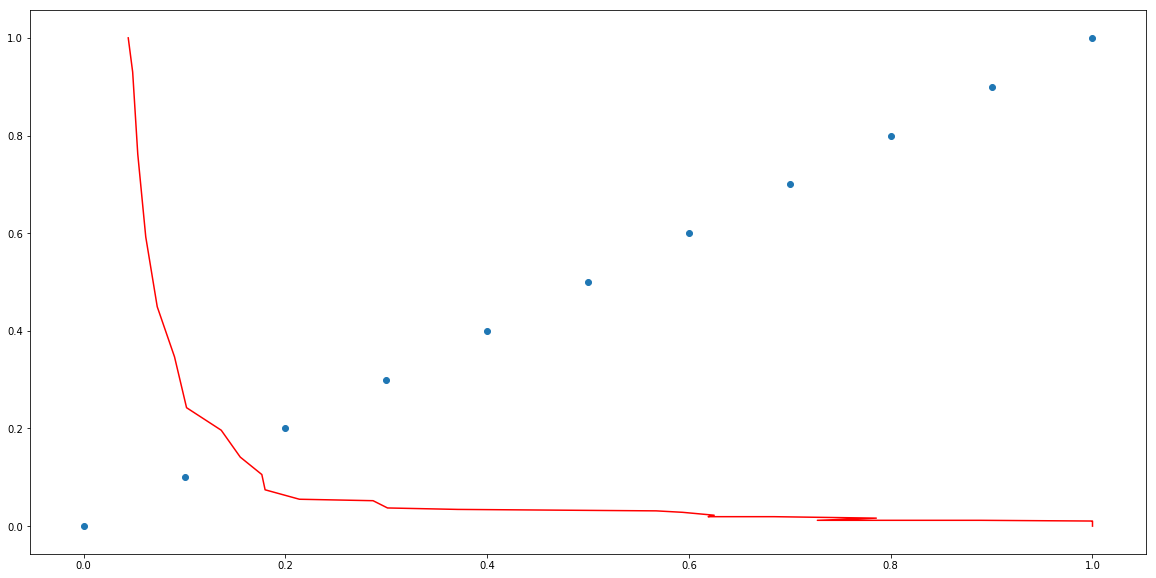

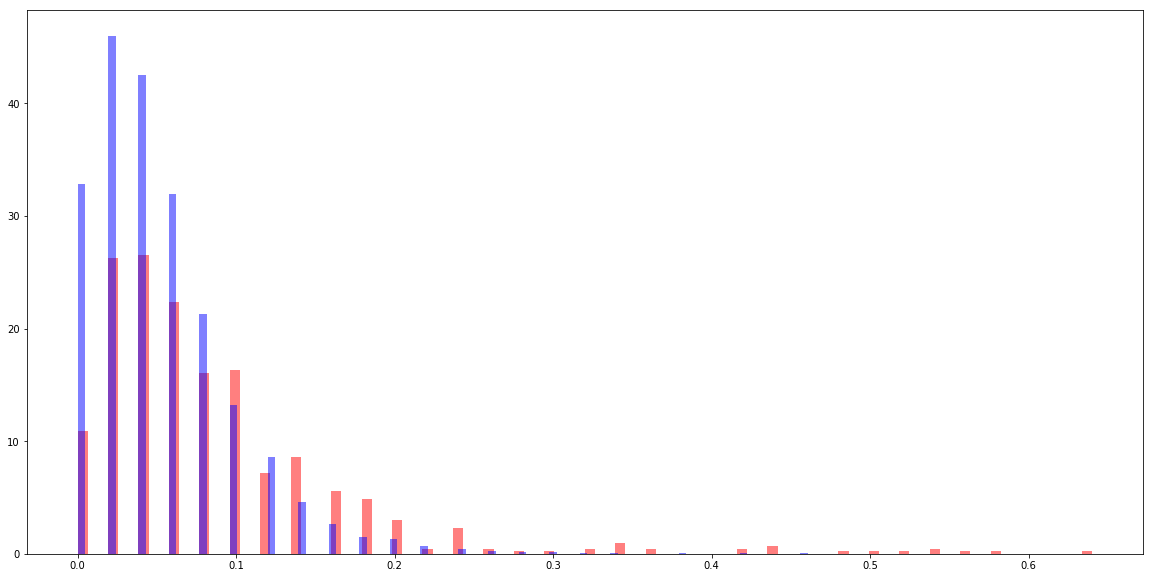

In [16]:
features = defaultdict(list)
_, _, pair_ids = experiments['4'].run()

for f, pair_id in zip(datasets['4'][0], pair_ids):
    signature = tuple(pairs[pair_id])
    features[signature].append(f)

In [17]:
for key, value in features.items():
    features[key] = np.array(value)

In [18]:
signatures = {
    '4': [
        ('fn', 'fn', 'fn'),
        ('fn', 'tp', 'tp'),
        ('tp', 'tp', 'tp'),
        ('fn', 'fn', 'tp'),
    ],
    '8': [
        ('na', 'fn', 'fn'),
        ('na', 'tp', 'tp'),
        ('na', 'fn', 'tp'),
    ],
    '11': [
        ('na', 'na', 'fn'), 
        ('na', 'na', 'tp'),
    ]
}

In [20]:
tsne_features = [
    'sequence lefts[1] length',
    'sequence lefts[1] count of A',
    'sequence lefts[1] count of U',
    'sequence lefts[1] count of G',
    'sequence lefts[1] count of C',
    'sequence lefts[1] count of M',
    'sequence lefts[1] count of N',
    'fragment type lefts[1] for first S',
    'fragment type lefts[1] for first H',
    'fragment type lefts[1] for first B',
    'fragment type lefts[1] for first I',
    'fragment type lefts[1] for first J',
    'fragment type lefts[1] for second C',
    'fragment type lefts[1] for second I',
    'fragment type lefts[1] for second P',
    'sequence rights[1] length',
    'sequence rights[1] count of A',
    'sequence rights[1] count of U',
    'sequence rights[1] count of G',
    'sequence rights[1] count of C',
    'sequence rights[1] count of M',
    'sequence rights[1] count of N',
    'fragment type rights[1] for first S',
    'fragment type rights[1] for first H',
    'fragment type rights[1] for first B',
    'fragment type rights[1] for first I',
    'fragment type rights[1] for first J',
    'fragment type rights[1] for second C',
    'fragment type rights[1] for second I',
    'fragment type rights[1] for second P',
]

tsne_mask = [datasets['4'][-1].index(f) for f in tsne_features]

In [21]:
def visualize(signatures):
    all_features = []
    all_colors = []

    for i, signature in enumerate(signatures):
        all_features.extend(features[signature])
        all_colors.extend([i] * features[signature].shape[0])
    
    all_features = np.array(all_features)[:, tsne_mask]
    all_colors = np.array(all_colors)
    
    normalized_features = (all_features - all_features.mean(axis=0)) / all_features.std(axis=0)
    transformed = TSNE(learning_rate=20, random_state=2).fit_transform(normalized_features)
    
    plt.figure(figsize=(20, 20))

    for i, signature in enumerate(signatures):
        mask = all_colors == i
        plt.scatter(transformed[mask, 0], transformed[mask, 1], label=signature, alpha=0.2, s=200)

    plt.legend()
    
    return all_features, all_colors, transformed

In [22]:
good_pairs = [
    ('fn', 'fn', 'tp'), 
    ('fn', 'tp', 'tp'),
    ('na', 'fn', 'tp'), 
    ('fn', 'fn', 'fn'), 
    ('tp', 'tp', 'tp')
]

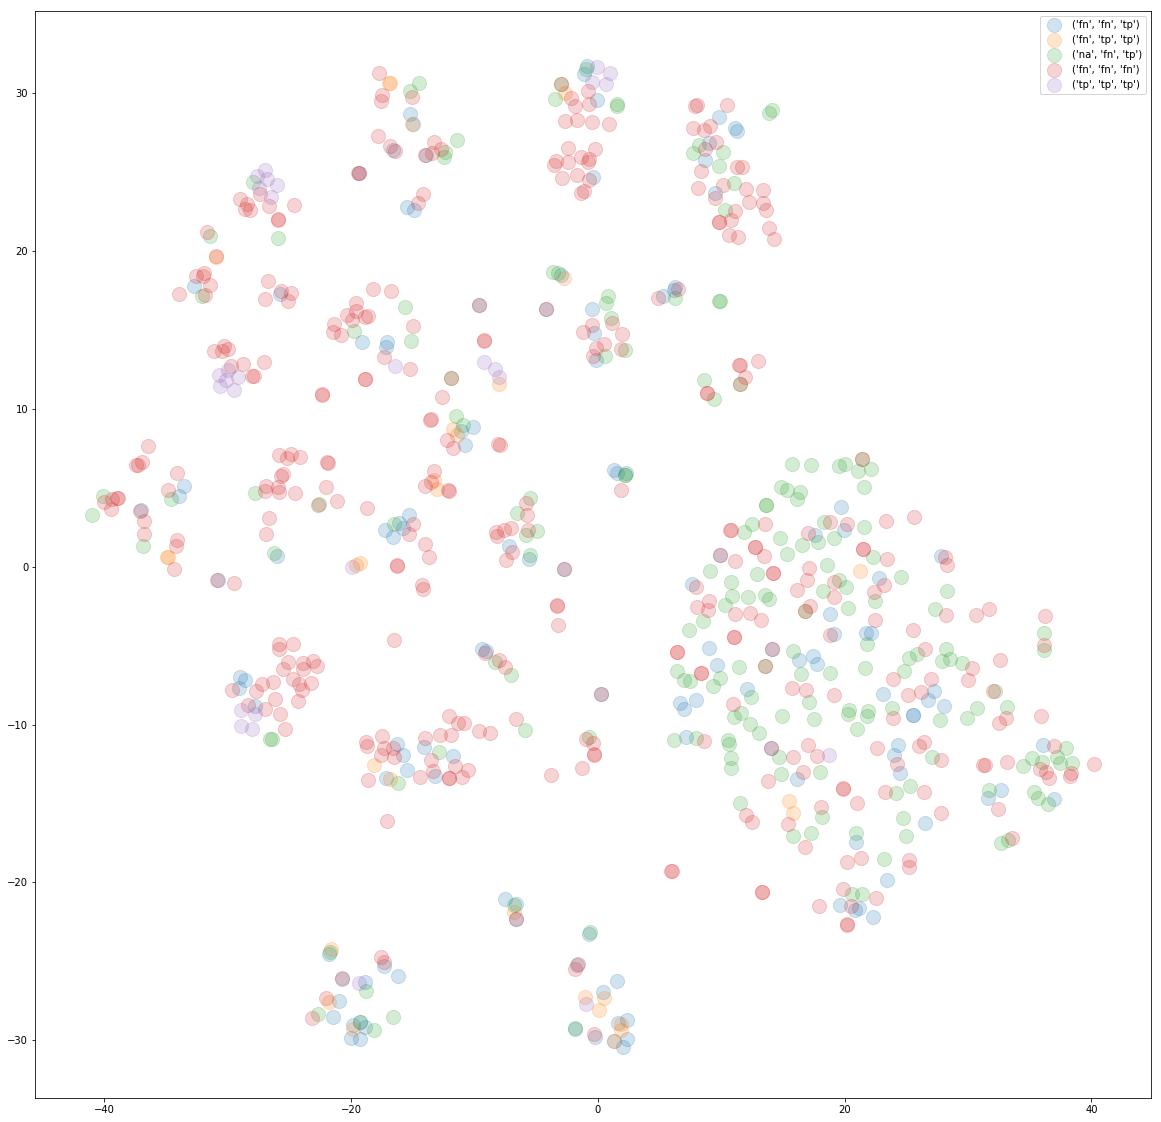

In [23]:
all_features, all_colors, transformed = visualize(good_pairs)

In [46]:
mask = (transformed[:, 1] > -20) & (transformed[:, 1] < -5) & (transformed[:, 0] > -100) & (transformed[:, 0] < -21) & (all_colors == 4)

In [47]:
other_mask = (transformed[:, 1] > -20) & (transformed[:, 1] < -5) & (transformed[:, 0] > -100) & (transformed[:, 0] < -21) & (all_colors != 4)

In [48]:
cluster = all_features[mask]
other = all_features[other_mask]

In [49]:
for name, m, s in zip(tsne_features, other.mean(axis=0), other.std(axis=0)):
    print(name, m, s)

sequence lefts[1] length 4.074074074074074 1.1840272120848727
sequence lefts[1] count of A 0.3333333333333333 0.6085806194501846
sequence lefts[1] count of U 0.7037037037037037 0.7608384660805236
sequence lefts[1] count of G 1.5185185185185186 0.738886568268889
sequence lefts[1] count of C 1.5185185185185186 0.9572479987644508
sequence lefts[1] count of M 0.0 0.0
sequence lefts[1] count of N 5.925925925925926 1.1840272120848727
fragment type lefts[1] for first S 1.0 0.0
fragment type lefts[1] for first H 0.0 0.0
fragment type lefts[1] for first B 0.0 0.0
fragment type lefts[1] for first I 0.0 0.0
fragment type lefts[1] for first J 0.0 0.0
fragment type lefts[1] for second C 0.0 0.0
fragment type lefts[1] for second I 0.0 0.0
fragment type lefts[1] for second P 0.0 0.0
sequence rights[1] length 5.555555555555555 1.4229164972072998
sequence rights[1] count of A 2.814814814814815 1.3343617433075423
sequence rights[1] count of U 0.9629629629629629 1.0708764662815526
sequence rights[1] coun

In [50]:
for name, m, s in zip(tsne_features, cluster.mean(axis=0), cluster.std(axis=0)):
    print(name, m, s)

sequence lefts[1] length 2.0 0.0
sequence lefts[1] count of A 0.0 0.0
sequence lefts[1] count of U 0.0 0.0
sequence lefts[1] count of G 1.0 1.0
sequence lefts[1] count of C 1.0 1.0
sequence lefts[1] count of M 0.0 0.0
sequence lefts[1] count of N 8.0 0.0
fragment type lefts[1] for first S 1.0 0.0
fragment type lefts[1] for first H 0.0 0.0
fragment type lefts[1] for first B 0.0 0.0
fragment type lefts[1] for first I 0.0 0.0
fragment type lefts[1] for first J 0.0 0.0
fragment type lefts[1] for second C 0.0 0.0
fragment type lefts[1] for second I 0.0 0.0
fragment type lefts[1] for second P 0.0 0.0
sequence rights[1] length 7.0 0.0
sequence rights[1] count of A 5.0 1.0
sequence rights[1] count of U 0.5 0.5
sequence rights[1] count of G 1.5 0.5
sequence rights[1] count of C 0.0 0.0
sequence rights[1] count of M 0.0 0.0
sequence rights[1] count of N 3.0 0.0
fragment type rights[1] for first S 0.0 0.0
fragment type rights[1] for first H 1.0 0.0
fragment type rights[1] for first B 0.0 0.0
frag